# 🧙‍♂️ Sample Generation with Pretrained Model + LLLA

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jac-Zac/PML_DL_Final_Project/blob/master/notebooks/notebook_llla_diff.ipynb)

### Initial setup ⚙️

### If runned locally

In [1]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

In [2]:
if IN_COLAB:
    !pip install laplace-torch -q 
    repo_dir = "PML_DL_Final_Project"
    
    if not os.path.exists(repo_dir):
        !git clone https://github.com/Jac-Zac/PML_DL_Final_Project.git
    else:
        print(f"Repository '{repo_dir}' already exists. Skipping clone.")

        
    if os.path.isdir(repo_dir):
        %cd $repo_dir
        !pip install dotenv -q
    else:
        print(f"Directory '{repo_dir}' not found. Please clone the repository first.")

else:
    %cd ..

/Users/jaczac/Github/PML_DL_Final_Project


### 📦 Imports

In [3]:
import torch

from src.models.diffusion import Diffusion
from src.utils.data import get_dataloaders
from src.utils.plots import plot_image_grid, plot_image_uncertainty_grid
from src.utils.environment import get_device, set_seed, load_pretrained_model
import os

# Since on a notebook we can have nicer bars
import tqdm.notebook as tqdm

### 🧪 Setup: Seed and Device

In [4]:
seed = 1337
set_seed(seed)
device = get_device()
os.makedirs("checkpoints", exist_ok=True)

## 💡 Image Generation

#### 🛠️ Configuration Parameters

In [5]:
n_samples = 5
save_dir = "samples"
max_steps = 1000
model_name = "unet"
method = "diffusion"  # or "flow"
ckpt_path = "checkpoints/best_model.pth"  # or use your last checkpoint

#### Define Class for QUDiffusion

In [6]:
from typing import List, Optional, Tuple
import torch
from torch import Tensor, nn

class UQDiffusion(Diffusion):
    """
    Diffusion model with uncertainty estimation capabilities.
    Extends the base Diffusion class to support Laplace approximation models.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def sample_from_gaussian(self, mean: Tensor, var: Tensor) -> Tensor:
        """Sample from Gaussian distribution with given mean and variance."""
        std = torch.sqrt(torch.clamp(var, min=1e-8))
        return mean + std * torch.randn_like(mean)

    def perform_training_step(
        self,
        model: nn.Module,
        x_0: Tensor,
        y: Optional[Tensor] = None,
        t: Optional[Tensor] = None,
    ) -> Tensor:
        """Override to use accurate_forward during training if available."""
        x_0 = x_0.to(self.device)
        if t is None:
            t = self._sample_timesteps(x_0.size(0))
        x_t, noise = self._sample_q(x_0, t)

        noise_pred = model(x_t, t, y=y)

        return self.loss_simple(noise, noise_pred)

    @torch.no_grad()
    def sample_step(
        self,
        model: nn.Module,
        x_t: Tensor,
        t: Tensor,
        y: Optional[Tensor] = None,
    ) -> Tensor:
        """
        Override sample_step to optionally include uncertainty.
        """
        return self._sample_step_with_uncertainty(model, x_t, t, y)

    @torch.no_grad()
    def monte_carlo_covariance_estim(
        self,
        model: nn.Module,
        t: Tensor,
        x_mean: Tensor,
        x_var: Tensor,
        S: int = 10,
        y: Optional[Tensor] = None,
    ) -> Tuple[Tensor, Tensor]:
        """
        Perform Monte Carlo sampling to estimate covariance matrix.
        Args:
            mean_x0: Mean of x_0 estimated by diffusion.
            var_x0: Variance of x_0 estimated by propagation.
            S: Number of Monte Carlo samples.

        Returns:
            mc_mean: Empirical mean of samples.
            mc_var: Empirical pixel-wise variance of samples.
        """

        std_x = torch.sqrt(torch.clamp(x_var, min=1e-8))
        x_samples = [x_mean + std_x * torch.randn_like(x_mean) for _ in range(S)]

        eps_samples = []

        for i in range(S):
            eps_mean_i, eps_var_i = model(x_samples[i], t, y=y)
            std_eps_i = torch.sqrt(torch.clamp(eps_var_i, min=1e-8))
            eps_samples.append(eps_mean_i + std_eps_i * torch.randn_like(eps_mean_i))

        x_samples = torch.stack(x_samples, dim=0)  # [S, B, C, H, W]
        eps_samples = torch.stack(eps_samples, dim=0)  # [S, B, C, H, W]

        first_term = 1 / S * torch.sum(x_samples * eps_samples, dim=0)  # [B, C, H, W]
        second_term = torch.mean(x_samples, dim=0) * torch.mean(eps_samples, dim=0) # [B, C, H, W]

        return first_term - second_term

    @torch.no_grad()
    def sample_with_uncertainty(
        self,
        model: nn.Module,
        t_sample_times: Optional[List[int]] = None,
        channels: int = 1,
        log_intermediate: bool = True,
        y: Optional[Tensor] = None,
        cov_num_sample: int = 10,
    ) -> Tuple[List[Tensor], List[Tensor], Optional[List[Tensor]]]:
        """
        Iteratively sample from the model, tracking predictive uncertainty and optionally Cov(x, ε).
        """
        model.eval()
        batch_size = 1 if y is None else y.size(0)

        x_t = torch.randn(
            batch_size, channels, self.img_size, self.img_size, device=self.device
        )
        x_t_mean = x_t.clone()
        x_t_var = torch.zeros_like(x_t)
        cov_t = torch.zeros_like(x_t)

        intermediates, uncertainties = [], []

        for i in reversed(range(self.noise_steps)):
            t = torch.full((batch_size,), i, device=self.device, dtype=torch.long)

            # Predict noise and its variance
            eps_mean, eps_var = model(x_t, t, y=y)  # mean and variance of noise

            # Compute xt-1
            beta_t = self.beta[t].view(-1, 1, 1, 1)
            alpha_t = self.alpha[t].view(-1, 1, 1, 1)
            alpha_bar_t = self.alpha_bar[t].view(-1, 1, 1, 1)

            # Mean and x_t-1
            coef1 = 1.0 / alpha_t.sqrt()
            coef2 = (1.0 - alpha_t) / (1.0 - alpha_bar_t).sqrt()
            x_prev_mean = coef1 * (x_t_mean - coef2 * eps_mean)
            x_prev = (
                coef1 * (x_t - coef2 * eps_mean) + torch.randn_like(x_t) * beta_t.sqrt()
            )

            # Variance
            coef3 = 2 * beta_t / (1 - alpha_bar_t).sqrt()
            coef4 = beta_t**2 / (1 - alpha_bar_t)
            x_prev_var = (
                1 / alpha_t * (x_t_var - coef3 * cov_t + coef4 * eps_var) + beta_t
            )

            if i > 0:
                # Covariance estimation with Monte Carlo
                covariance = self.monte_carlo_covariance_estim(
                    model=model,
                    t=t - 1,
                    x_mean=x_prev_mean,
                    x_var=x_prev_var,
                    S=cov_num_sample,
                    y=y,
                )

            # Log intermediate images
            if log_intermediate and t_sample_times and i in t_sample_times:
                intermediates.append(self.transform_sampled_image(x_t.clone()))
                uncertainties.append(x_t_var.clone().cpu())  # per-pixel variance

            x_t = x_prev
            x_t_mean = x_prev_mean
            x_t_var = x_prev_var
            cov_t = covariance

        uncertainties = torch.stack(uncertainties)  # [num_steps, B, C, H, W]

        model.train()
        return intermediates, uncertainties

    @torch.no_grad()
    def sample(
        self,
        model: nn.Module,
        t_sample_times: Optional[List[int]] = None,
        channels: int = 1,
        log_intermediate: bool = False,
        y: Optional[Tensor] = None,
    ) -> Tuple[List[Tensor], List[Tensor]]:
        """
        Override sample method to optionally use uncertainty.

        If uncertainty_schedule is provided, uses uncertainty sampling,
        otherwise falls back to deterministic sampling for backward compatibility.
        """
        intermediates, _, _ = self.sample_with_uncertainty(
            model=model,
            t_sample_times=t_sample_times,
            channels=channels,
            log_intermediate=log_intermediate,
            y=y,
        )
        return intermediates

### 💪 Fit Laplace approximation

In [7]:
from src.models.llla_model import LaplaceApproxModel
from src.utils.data import get_llla_dataloader
from types import SimpleNamespace


num_classes = 10

# Load pretrained MAP model using best checkpoint
diff_model = load_pretrained_model(
    model_name="unet",
    ckpt_path="jac-zac/diffusion-project/best-model:v22",
    device=device,
    model_kwargs={"num_classes": num_classes, "time_emb_dim": 128},
    use_wandb=True,
)

# 2️⃣ Prepare data loaders for the Laplace fit
train_loader, _ = get_llla_dataloader(batch_size=128)

mnist_config = SimpleNamespace()
mnist_config.data = SimpleNamespace()
mnist_config.data.image_size = 28  # MNIST image size

# Wrap diffusion model with your Custom Model for Laplace last layer approx
# NOTE: Automatically call fit
laplace_model = LaplaceApproxModel(
    diff_model, train_loader, args=None, config=mnist_config
)

print("Laplace fitting completed on last layer of the diffusion model.")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: WARNING Unable to write /Users/jaczac/.config/netrc/netrc
wandb: Currently logged in as: jacopozac (jac-zac) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb:   1 of 1 files downloaded.  
                                                                                                                                                                                    

Laplace fitting completed on last layer of the diffusion model.



<!-- #region id="1d2b6a2d" -->
### 💨 Initialize Diffusion Process

<!-- #endregion -->

In [8]:
# Initialize uncertainty-aware diffusion (same interface as base class)
diffusion = UQDiffusion(img_size=28, device=device)

In [9]:
import matplotlib.pyplot as plt
import numpy as np


def plot_image_uncertainty_grid(
    model,
    method_instance,
    n: int,
    num_intermediate: int,
    max_steps: int,
    save_dir: str,
    device: torch.device,
    num_classes: int,
    cov_num_sample: int = 50,
    uq_cmp: str = "grey"
):
    """
    Generate and plot a grid of intermediate samples for either diffusion or flow.

    Args:
        model: The trained model.
        method_instance: The sampling method instance (Diffusion or FlowMatching).
        n (int): Number of classes from which to generate ([0,1,..,n-1]).
        num_intermediate (int): Number of intermediate steps to visualize.
        max_steps (int): Maximum number of steps or timesteps.
        save_dir (str): Directory to save the output image.
        device: Torch device.
        num_classes (int): Number of classes for label conditioning.
    """
    # Prepare conditioning labels
    y = torch.arange(n, device=device) % num_classes

    # Decide which type of timesteps to generate
    # if method_instance.__class__.__name__ == "FlowMatching":
    #     # Flow matching: choose indices between 0 and (steps-1)
    #     step_indices = torch.linspace(
    #         0, max_steps - 1, steps=num_intermediate, dtype=torch.int32
    #     ).tolist()

    #     all_samples_grouped = method_instance.sample(
    #         model,
    #         steps=max_steps,
    #         log_intermediate=True,
    #         t_sample_times=step_indices,
    #         y=y,
    #     )
    #     timesteps = step_indices
    # else:
        # Diffusion: choose timesteps between max_steps and 0
    t_sample_times = torch.linspace(
        max_steps-1,
        0,
        steps=num_intermediate,
        dtype=torch.int32,
    ).tolist()
    print("sample times", t_sample_times)

    all_samples_grouped, uncertainties = method_instance.sample_with_uncertainty(
        model,
        t_sample_times=t_sample_times,
        log_intermediate=True,
        y=y,
        cov_num_sample=cov_num_sample,
    )
    timesteps = t_sample_times

    ### ------------------ Plot images grid ------------------ ###

    # Stack all generated images into a (B, T, C, H, W) tensor
    stacked = torch.stack(all_samples_grouped)  # (T, B, C, H, W)
    permuted = stacked.permute(1, 0, 2, 3, 4)  # (B, T, C, H, W)
    num_samples, num_timesteps = permuted.shape[:2]   # extract B and T
    print("num timesteps", num_timesteps)

    # Save as a grid
    os.makedirs(save_dir, exist_ok=True)
    out_path_img = os.path.join(save_dir, "all_samples_grid.png")

    fig, axes = plt.subplots(
        num_samples, num_intermediate, figsize=(1.5 * num_intermediate, 1.5 * num_samples)
    )

    if num_samples == 1:
        axes = np.expand_dims(axes, 0)
    if num_intermediate == 1:
        axes = np.expand_dims(axes, 1)

    indices = np.linspace(0, num_timesteps - 1, num=num_intermediate, dtype=int)

    for row in range(num_samples):
        for idx, col in enumerate(indices):
            img = permuted[row, col].squeeze().cpu().numpy()
            ax = axes[row, col]
            ax.imshow(img, cmap="gray")
            ax.axis("off")
            if row == 0:
                ax.set_title(f"step={timesteps[col]}", fontsize=10)
            if col == 0:
                ax.set_ylabel(f"Sample {row+1}", fontsize=10)

    plt.tight_layout()
    plt.savefig(out_path_img, bbox_inches="tight")
    plt.close()


    ### ------------------ Plot uncertainties grid ------------------ ###

    # Convert uncertainties to tensor if needed
    if isinstance(uncertainties, list):
        uncertainties = torch.stack(uncertainties)  # (T, B, C, H, W)

    # Multiplier
    mult = 700

    # Ensure uncertainties has same ordering: (B, T, C, H, W)
    uncertainties_permuted = uncertainties.permute(1, 0, 2, 3, 4) * mult

    out_path_unc = os.path.join(save_dir, "all_uncertainties_grid.png")

    fig, axes = plt.subplots(
        num_samples, num_intermediate, figsize=(1.5 * num_intermediate, 1.5 * num_samples)
    )

    if num_samples == 1:
        axes = np.expand_dims(axes, 0)
    if num_intermediate == 1:
        axes = np.expand_dims(axes, 1)

    for row in range(num_samples):
        for col in range(num_intermediate):
            unc = uncertainties_permuted[row, col].squeeze().cpu().numpy()
            ax = axes[row, col]
            im = ax.imshow(unc, cmap=uq_cmp)  # Heatmap for uncertainty
            ax.axis("off")
            if row == 0:
                ax.set_title(f"step={timesteps[col]}", fontsize=10)
            if col == 0:
                ax.set_ylabel(f"Sample {row+1}", fontsize=10)

    plt.tight_layout()
    plt.savefig(out_path_unc, bbox_inches="tight")
    plt.close()

    return all_samples_grouped, uncertainties


In [16]:
%%time
num_intermediate = 20

all_samples_grouped, uncertainties = plot_image_uncertainty_grid(
        laplace_model,
        diffusion,
        num_intermediate=num_intermediate,
        n=1,
        max_steps=max_steps,
        save_dir=save_dir,
        device=device,
        num_classes=num_classes,
        cov_num_sample=10,
    )

sample times [999, 946, 893, 841, 788, 736, 683, 630, 578, 525, 473, 420, 368, 315, 262, 210, 157, 105, 52, 0]
num timesteps 20
CPU times: user 1min, sys: 7 s, total: 1min 7s
Wall time: 1min


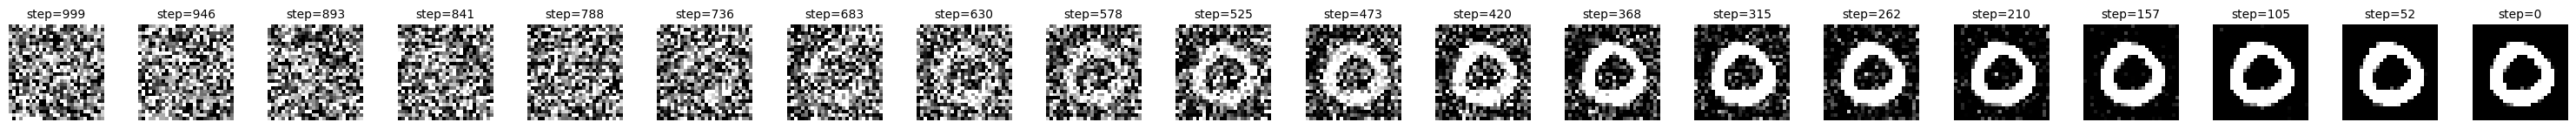

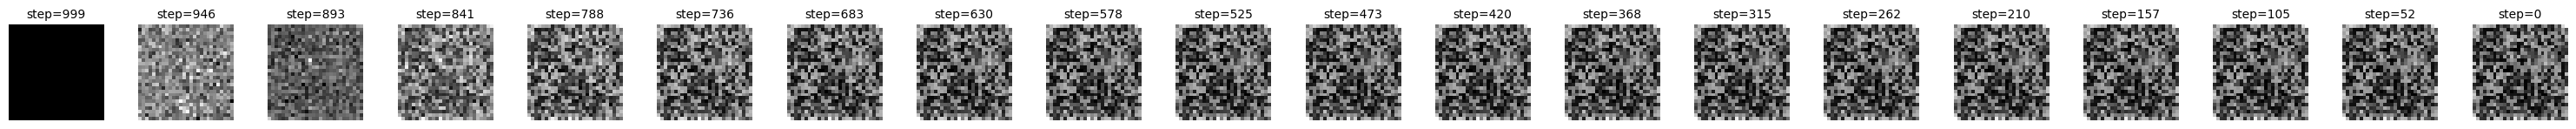

In [17]:
from PIL import Image

# Display samples grid
out_path_img = os.path.join(save_dir, "all_samples_grid.png")
display(Image.open(out_path_img))

# Display uncertainties grid
out_path_unc = os.path.join(save_dir, "all_uncertainties_grid.png")
display(Image.open(out_path_unc))

In [18]:
print(uncertainties.shape)

torch.Size([20, 1, 1, 28, 28])


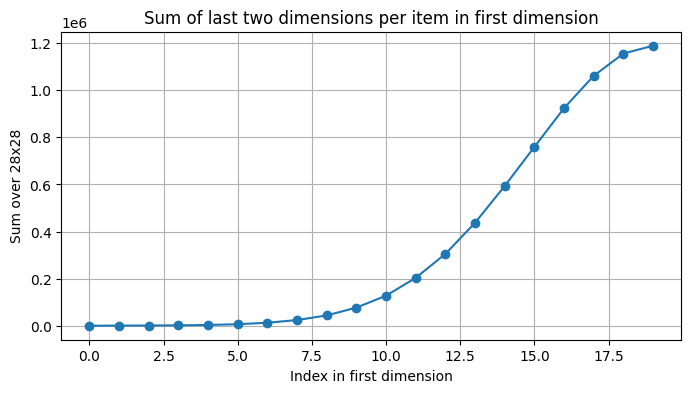

In [19]:
import torch
import matplotlib.pyplot as plt
# Sum over the last two dimensions (28x28)
sums = uncertainties.sum(dim=[-1, -2])  # shape: [10, 1, 1]

# Flatten to shape
sums_flat = sums.view(num_intermediate)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(range(num_intermediate), sums_flat.tolist(), marker='o', linestyle='-')
plt.title("Sum of last two dimensions per item in first dimension")
plt.xlabel("Index in first dimension")
plt.ylabel("Sum over 28x28")
plt.grid(True)
plt.show()